In [1]:
import pandas as pd


In [2]:
df=pd.read_csv("level1_output.csv")

In [3]:
df

,from,sender_domain,clean_text,deadline_date,label_source,label_topic,label_urgency
0,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,request for email data contribution – research...,NaN,Student / Club,NaN,NaN
1,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,re: request for email data contribution – rese...,NaN,Student / Club,NaN,NaN
2,NPTEL <onlinecourses@nptel.iitm.ac.in>,nptel.iitm.ac.in,nptel newsletter: iit madras code certificate ...,NaN,External Course Provider,NaN,NaN
3,Team at Read <support@e.read.ai>,e.read.ai,exclusive education pricing just for you! read...,NaN,Misc / External,NaN,NaN
4,Mohini Darji <mohinidarji.dcs@charusat.ac.in>,charusat.ac.in,reg. submission of sgp- weekly reports dear st...,NaN,Faculty / Academic Staff,NaN,NaN
...,...,...,...,...,...,...,...
1531,WISSENAIRE TEACHNOOK TRAINING AND INTERNSHIP C...,gmail.com,exclusive upskilling program for charusat firs...,NaN,Misc / External,NaN,NaN
1532,Krishna Patel <krishnapatel.ce@charusat.ac.in>,charusat.ac.in,"ce143- ccp unit tese-1 syllabus dear students,...",NaN,Faculty / Academic Staff,NaN,NaN
1533,Vaishali Vadhavana <vaishalivadhavana.dcs@char...,charusat.ac.in,regarding permanent student id for fy 2023 cse...,NaN,Administration / Office,NaN,NaN
1534,Gmail Team <mail-noreply@google.com>,google.com,tips for using your new inbox tips for using y...,NaN,Misc / External,NaN,NaN


                          count  percent
label_source                            
Faculty / Academic Staff    643    41.86
Misc / External             429    27.93
Administration / Office     275    17.90
External Course Provider    140     9.11
Student / Club               49     3.19


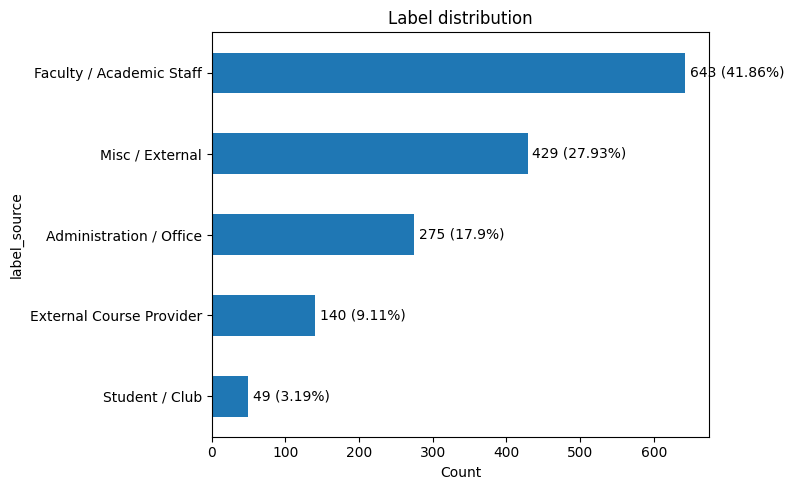

In [4]:
# show distribution of labels (counts + percentages) and plot a horizontal bar chart
label_series = df['label_source'].fillna('Unlabeled')
counts = label_series.value_counts()
percents = label_series.value_counts(normalize=True).mul(100).round(2)
dist = pd.concat([counts, percents], axis=1, keys=['count', 'percent'])
print(dist)

import matplotlib.pyplot as plt

counts_sorted = counts.sort_values(ascending=True)
plt.figure(figsize=(8, 5))
ax = counts_sorted.plot(kind='barh', color='C0')
plt.xlabel('Count')
plt.title('Label distribution')
# annotate counts on bars
for i, (idx, v) in enumerate(counts_sorted.items()):
    ax.text(v + max(counts_sorted) * 0.01, i, f"{v} ({dist.loc[idx,'percent']}%)", va='center')
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

# -------------------------------------------------------
# TTS Engine Setup
# -------------------------------------------------------
try:
    import pyttsx3
    tts_engine = None

    def speak(text):
        global tts_engine
        if tts_engine is None:
            tts_engine = pyttsx3.init()
        try:
            tts_engine.say(text)
            tts_engine.runAndWait()
        except Exception as e:
            print("[TTS ERROR]", e)

except ImportError:
    def speak(text):
        pass


# -------------------------------------------------------
# Allowed Level-1 Source Labels
# -------------------------------------------------------
ALLOWED_SOURCES = [
    "Administration / Office",
    "Faculty / Academic Staff",
    "Student / Club",
    "External Course Provider",
    "Misc / External",
]

# Ensure verification column exists
if "label_source_verified" not in df.columns:
    df["label_source_verified"] = df.get("label_source", "")


# Helper for manual selection
def choose_new_label():
    print("\nChoose a new label_source from:")
    for i, lab in enumerate(ALLOWED_SOURCES, start=1):
        print(f"  {i}. {lab}")
    while True:
        choice = input("Enter number (1–5) or exact label: ").strip()
        if choice.isdigit():
            idx = int(choice)
            if 1 <= idx <= len(ALLOWED_SOURCES):
                return ALLOWED_SOURCES[idx - 1]
            print("Invalid number.")
        elif choice in ALLOWED_SOURCES:
            return choice
        else:
            print("Invalid choice, retry.")


# -------------------------------------------------------
# Review Loop with batching and skip verified rows
# -------------------------------------------------------
BATCH_SIZE=300
count = 0


for idx, row in df.iterrows():

    # SKIP if already verified


    print("\n" + "-"*80)
    print(f"Row index: {idx}")
    print(f"From           : {row.get('from', '')}")
    print(f"Sender domain  : {row.get('sender_domain', '')}")

    preview = str(row.get("clean_text", ""))[:400]
    print("\nclean_text preview:\n", preview)

    current_label = row.get("label_source", "")
    print("\nCurrent label_source:", repr(current_label))

    new_label=row.get("label_source_verified", "")
    print("\nnew Label_source:", repr(new_label))



    # TTS preview
    try:
        speak(f"Row {idx}")
        speak(f"From {row.get('from', '')}")
        speak(f"Suggested source {current_label}")
        speak(preview[:250])
    except Exception as e:
        print("[TTS ERROR]", e)

    # manual confirmation
    ans = input("Is this label correct? [y = yes / n = no / q = quit]: ").strip().lower()

    if ans == "q":
        print("\nStopping review loop.")
        break
    elif ans in ["y", ""]:
        df.at[idx, "label_source_verified"] = current_label
        print("✔ Kept")
    else:
        new_label = choose_new_label()
        df.at[idx, "label_source_verified"] = new_label
        print("✔ Updated:", new_label)

    count += 1
    if count % BATCH_SIZE == 0:
        speak(f"Processed {count} emails. Do you want to continue?")
        print(f"\nProcessed {count} emails.")
        cont = input("Continue next batch? (y/n): ").strip().lower()
        if cont != "y":
            print("Ending batch session.")
            break

print("\nReview completed or paused. Verified values in df['label_source_verified'].")



--------------------------------------------------------------------------------
Row index: 0
From           : 23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat.edu.in>
Sender domain  : charusat.edu.in

clean_text preview:
 request for email data contribution – research acknowledgment included dear student thank you so much for your willingness to support our research project. we truly appreciate your help in improving the accuracy and effectiveness of our academic email classification model. as promised, your data will be used strictly for academic purposes, and only informational emails will be processed. your cont

Current label_source: 'Student / Club'

new Label_source: 'Student / Club'
✔ Kept

--------------------------------------------------------------------------------
Row index: 1
From           : 23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat.edu.in>
Sender domain  : charusat.edu.in

clean_text preview:
 re: request for email data contribution – research acknowledgment included

In [17]:
df

,from,sender_domain,clean_text,deadline_date,label_source,label_topic,label_urgency,label_source_verified
0,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,request for email data contribution – research...,NaN,Student / Club,NaN,NaN,Student / Club
1,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,re: request for email data contribution – rese...,NaN,Student / Club,NaN,NaN,Student / Club
2,NPTEL <onlinecourses@nptel.iitm.ac.in>,nptel.iitm.ac.in,nptel newsletter: iit madras code certificate ...,NaN,External Course Provider,NaN,NaN,External Course Provider
3,Team at Read <support@e.read.ai>,e.read.ai,exclusive education pricing just for you! read...,NaN,Misc / External,NaN,NaN,Misc / External
4,Mohini Darji <mohinidarji.dcs@charusat.ac.in>,charusat.ac.in,reg. submission of sgp- weekly reports dear st...,NaN,Faculty / Academic Staff,NaN,NaN,Faculty / Academic Staff
...,...,...,...,...,...,...,...,...
1531,WISSENAIRE TEACHNOOK TRAINING AND INTERNSHIP C...,gmail.com,exclusive upskilling program for charusat firs...,NaN,Misc / External,NaN,NaN,Misc / External
1532,Krishna Patel <krishnapatel.ce@charusat.ac.in>,charusat.ac.in,"ce143- ccp unit tese-1 syllabus dear students,...",NaN,Faculty / Academic Staff,NaN,NaN,Faculty / Academic Staff
1533,Vaishali Vadhavana <vaishalivadhavana.dcs@char...,charusat.ac.in,regarding permanent student id for fy 2023 cse...,NaN,Administration / Office,NaN,NaN,Administration / Office
1534,Gmail Team <mail-noreply@google.com>,google.com,tips for using your new inbox tips for using y...,NaN,Misc / External,NaN,NaN,Misc / External


In [18]:
df.loc[:299, 'label_source'] = df.loc[:299, 'label_source_verified']

In [ ]:
# Empty label_source after row 300 and remove the verified column
df.loc[300:, 'label_source'] = ' '
df = df.drop(columns=['label_source_verified'])

In [24]:
import numpy as np

df.loc[300:, "label_source"] = np.nan


In [25]:
df

,from,sender_domain,clean_text,deadline_date,label_source,label_topic,label_urgency
0,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,request for email data contribution – research...,NaN,Student / Club,NaN,NaN
1,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,re: request for email data contribution – rese...,NaN,Student / Club,NaN,NaN
2,NPTEL <onlinecourses@nptel.iitm.ac.in>,nptel.iitm.ac.in,nptel newsletter: iit madras code certificate ...,NaN,External Course Provider,NaN,NaN
3,Team at Read <support@e.read.ai>,e.read.ai,exclusive education pricing just for you! read...,NaN,Misc / External,NaN,NaN
4,Mohini Darji <mohinidarji.dcs@charusat.ac.in>,charusat.ac.in,reg. submission of sgp- weekly reports dear st...,NaN,Faculty / Academic Staff,NaN,NaN
...,...,...,...,...,...,...,...
1531,WISSENAIRE TEACHNOOK TRAINING AND INTERNSHIP C...,gmail.com,exclusive upskilling program for charusat firs...,NaN,NaN,NaN,NaN
1532,Krishna Patel <krishnapatel.ce@charusat.ac.in>,charusat.ac.in,"ce143- ccp unit tese-1 syllabus dear students,...",NaN,NaN,NaN,NaN
1533,Vaishali Vadhavana <vaishalivadhavana.dcs@char...,charusat.ac.in,regarding permanent student id for fy 2023 cse...,NaN,NaN,NaN,NaN
1534,Gmail Team <mail-noreply@google.com>,google.com,tips for using your new inbox tips for using y...,NaN,NaN,NaN,NaN


In [26]:
df.to_csv("manual_level1_output.csv",index=False)

In [27]:
df_train = df.loc[:299].copy()   # only manually labeled rows


In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Use only verified section of dataset
df_train = df.loc[:299].copy()
df_train = df_train.dropna(subset=["label_source"])   # ensure valid labels

X = df_train["clean_text"]
y = df_train["label_source"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=6000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("logreg", LogisticRegression(max_iter=300, n_jobs=-1))
])

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))


                          precision    recall  f1-score   support

 Administration / Office       1.00      0.20      0.33         5
External Course Provider       1.00      1.00      1.00         3
Faculty / Academic Staff       0.80      0.92      0.86        13
         Misc / External       0.92      1.00      0.96        34
          Student / Club       1.00      0.80      0.89         5

                accuracy                           0.90        60
               macro avg       0.94      0.78      0.81        60
            weighted avg       0.91      0.90      0.88        60



In [30]:
df

,from,sender_domain,clean_text,deadline_date,label_source,label_topic,label_urgency,label_source_verified
0,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,request for email data contribution – research...,NaN,Student / Club,NaN,NaN,Student / Club
1,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,re: request for email data contribution – rese...,NaN,Student / Club,NaN,NaN,Student / Club
2,NPTEL <onlinecourses@nptel.iitm.ac.in>,nptel.iitm.ac.in,nptel newsletter: iit madras code certificate ...,NaN,External Course Provider,NaN,NaN,External Course Provider
3,Team at Read <support@e.read.ai>,e.read.ai,exclusive education pricing just for you! read...,NaN,Misc / External,NaN,NaN,Misc / External
4,Mohini Darji <mohinidarji.dcs@charusat.ac.in>,charusat.ac.in,reg. submission of sgp- weekly reports dear st...,NaN,Faculty / Academic Staff,NaN,NaN,Faculty / Academic Staff
...,...,...,...,...,...,...,...,...
1531,WISSENAIRE TEACHNOOK TRAINING AND INTERNSHIP C...,gmail.com,exclusive upskilling program for charusat firs...,NaN,NaN,NaN,NaN,NaN
1532,Krishna Patel <krishnapatel.ce@charusat.ac.in>,charusat.ac.in,"ce143- ccp unit tese-1 syllabus dear students,...",NaN,NaN,NaN,NaN,NaN
1533,Vaishali Vadhavana <vaishalivadhavana.dcs@char...,charusat.ac.in,regarding permanent student id for fy 2023 cse...,NaN,NaN,NaN,NaN,NaN
1534,Gmail Team <mail-noreply@google.com>,google.com,tips for using your new inbox tips for using y...,NaN,NaN,NaN,NaN,NaN


In [33]:
import pandas as pd

# -------------------------------------------------------
# TTS Engine Setup
# -------------------------------------------------------
try:
    import pyttsx3
    tts_engine = None

    def speak(text):
        global tts_engine
        if tts_engine is None:
            tts_engine = pyttsx3.init()
        try:
            tts_engine.say(text)
            tts_engine.runAndWait()
        except Exception as e:
            print("[TTS ERROR]", e)

except ImportError:
    def speak(text):
        pass


# -------------------------------------------------------
# Allowed Level-1 Source Labels
# -------------------------------------------------------
ALLOWED_SOURCES = [
    "Administration / Office",
    "Faculty / Academic Staff",
    "Student / Club",
    "External Course Provider",
    "Misc / External",
]

# Ensure verification column exists
if "label_source_verified" not in df.columns:
    df["label_source_verified"] = df.get("label_source", "")


# Manual selection helper
def choose_new_label():
    print("\nAvailable source labels:")
    for i, lab in enumerate(ALLOWED_SOURCES, start=1):
        print(f"  {i}. {lab}")
    while True:
        choice = input("Enter number (1–5), exact label, or press Enter to keep suggested: ").strip()
        if choice == "":
            return None  # means keep existing
        if choice.isdigit():
            idx = int(choice)
            if 1 <= idx <= len(ALLOWED_SOURCES):
                return ALLOWED_SOURCES[idx - 1]
            print("Invalid number.")
        elif choice in ALLOWED_SOURCES:
            return choice
        else:
            print("Invalid choice, retry.")


# -------------------------------------------------------
# Review Loop starting after row 300
# -------------------------------------------------------
BATCH_SIZE = 300
count = 0

for idx, row in df.iterrows():

    if idx < 300:
        continue  # skip already manually labeled samples

    print("\n" + "-" * 80)
    print(f"Row index: {idx}")
    print(f"From           : {row.get('from', '')}")
    print(f"Sender domain  : {row.get('sender_domain', '')}")

    preview = str(row.get("clean_text", ""))[:400]
    print("\nclean_text preview:\n", preview)

    current_label = str(row.get("label_source", "")).strip() if pd.notna(row.get("label_source")) else ""
    print("\nSuggested label_source:", repr(current_label))

    # TTS preview
    try:
        speak(f"Row {idx}")
        speak(f"From {row.get('from', '')}")
        speak(f"Suggested source {current_label}")
        speak(preview[:250])
    except Exception as e:
        print("[TTS ERROR]", e)

    # Direct label assignment prompt
    print("\nAssign label_source (Enter = keep suggestion / number or text to change / q = quit):")
    new_label = choose_new_label()

    if new_label is None:  # keep existing suggestion
        df.at[idx, "label_source_verified"] = current_label
        print("✔ Kept existing suggestion.")
    elif new_label == "q":
        print("Stopping review loop.")
        break
    else:
        df.at[idx, "label_source_verified"] = new_label
        print(f"✔ Updated to: {new_label}")

    count += 1

    if count % BATCH_SIZE == 0:
        speak(f"Processed {count} emails. Do you want to continue?")
        print(f"\nProcessed {count} emails.")
        cont = input("Continue next batch? (y/n): ").strip().lower()
        if cont != "y":
            print("Ending batch session.")
            break

print("\nReview completed or paused. Verified values saved in 'label_source_verified'.")



--------------------------------------------------------------------------------
Row index: 300
From           : Coursera <Coursera@m.learn.coursera.org>
Sender domain  : m.learn.coursera.org

clean_text preview:
 recommended: ai for everyone nan

Suggested label_source: ''

Assign label_source (Enter = keep suggestion / number or text to change / q = quit):

Available source labels:
  1. Administration / Office
  2. Faculty / Academic Staff
  3. Student / Club
  4. External Course Provider
  5. Misc / External
✔ Updated to: Misc / External

--------------------------------------------------------------------------------
Row index: 301
From           : Google Forms <forms-receipts-noreply@google.com>
Sender domain  : google.com

clean_text preview:
 internship form - 2025 google forms thanks for filling out internship form - 2025 here's what was received. edit response internship form - 2025 your email (23dcs023@charusat.edu.in) was recorded when you submitted this form. name * james 

In [34]:
df.loc[300:599, 'label_source'] = df.loc[300:599, 'label_source_verified']

In [59]:
df.loc[583]

from                     23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....
sender_domain                                              charusat.edu.in
clean_text                      sgp: project proposal project proposal.pdf
deadline_date                                                          NaN
label_source                                               Misc / External
label_topic                                                            NaN
label_urgency                                                          NaN
label_source_verified                                      Misc / External
Name: 583, dtype: object

In [60]:
df.loc[583,'label_source']="Student / Club"

In [64]:
df_train = df.loc[:599].copy()   # only manually labeled rows


In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Use only verified section of dataset
df_train = df_train.dropna(subset=["label_source"])   # ensure valid labels

X = df_train["clean_text"]
y = df_train["label_source"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=6000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("logreg", LogisticRegression(max_iter=300, n_jobs=-1))
])

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))


                          precision    recall  f1-score   support

 Administration / Office       1.00      0.55      0.71        11
External Course Provider       0.94      1.00      0.97        17
Faculty / Academic Staff       0.89      0.97      0.93        34
         Misc / External       0.93      1.00      0.96        52
          Student / Club       1.00      0.50      0.67         6

                accuracy                           0.93       120
               macro avg       0.95      0.80      0.85       120
            weighted avg       0.93      0.93      0.92       120



In [66]:

print("Training set distribution:\n")
print(df_train["label_source"].value_counts())
print("\nPercentage distribution:\n")

Training set distribution:

label_source
Misc / External             259
Faculty / Academic Staff    172
External Course Provider     85
Administration / Office      53
Student / Club               31
Name: count, dtype: int64

Percentage distribution:



In [78]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# -------------------------------------------
# 1. Drop temporary helper columns ONLY
# -------------------------------------------
cols_to_drop = [
    "label_source_verified",
    "label_source_predicted",
    "prediction_confidence",
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")

print("Columns remaining:", df.columns.tolist())

# -------------------------------------------
# 2. Build combined text feature (domain + clean_text)
#    This is the key change 👇
# -------------------------------------------
def build_feature(series_domain, series_text):
    dom = series_domain.fillna("").astype(str)
    txt = series_text.fillna("").astype(str)
    # you can weight domain more by repeating it, e.g. (dom + " ") * 2 + txt
    return dom + " " + txt

# Train / test / unlabeled splits
df_train = df.iloc[:500].copy()
df_test  = df.iloc[500:600].copy()    # for evaluation if you want
df_unlabeled = df.iloc[600:].copy()   # real inference

X_train = build_feature(df_train["sender_domain"], df_train["clean_text"])
y_train = df_train["label_source"].fillna("").astype(str)

X_test  = build_feature(df_test["sender_domain"], df_test["clean_text"])
y_test  = df_test["label_source"].fillna("").astype(str)

X_unlabeled = build_feature(df_unlabeled["sender_domain"], df_unlabeled["clean_text"])

# -------------------------------------------
# 3. Train TF-IDF + Logistic Regression
# -------------------------------------------
clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=6000,
        ngram_range=(1, 2),
        stop_words="english"
    )),
    ("logreg", LogisticRegression(max_iter=350, n_jobs=-1))
])

clf.fit(X_train, y_train)

# (Optional) evaluate on 500–599
from sklearn.metrics import classification_report
y_pred_test = clf.predict(X_test)
print("\n=== Eval on rows 500–599 ===")
print(classification_report(y_test, y_pred_test))

# -------------------------------------------
# 4. Predict label_source for rows 600+
# -------------------------------------------
preds = clf.predict(X_unlabeled)
conf  = clf.predict_proba(X_unlabeled).max(axis=1)

df_unlabeled["prediction_confidence"] = conf
df_unlabeled["label_source"] = preds

df.loc[df_unlabeled.index, "label_source"] = preds
df.loc[df_unlabeled.index, "prediction_confidence"] = conf

# -------------------------------------------
# 5. Save output
# -------------------------------------------
df.to_csv("level1_final_clean_predictions.csv", index=False, encoding="utf-8")
print("Saved predictions to level1_final_clean_predictions.csv")


Columns remaining: ['from', 'sender_domain', 'clean_text', 'deadline_date', 'label_source', 'label_topic', 'label_urgency']

=== Eval on rows 500–599 ===
                          precision    recall  f1-score   support

 Administration / Office       1.00      0.22      0.36         9
External Course Provider       1.00      1.00      1.00        32
Faculty / Academic Staff       0.76      0.93      0.84        28
         Misc / External       0.91      0.97      0.94        30
          Student / Club       0.00      0.00      0.00         1

                accuracy                           0.89       100
               macro avg       0.73      0.62      0.63       100
            weighted avg       0.90      0.89      0.87       100



c:\Users\Vansh Malani\Documents\GitHub\Uni-Dash_Reborn\Machine_Learning_Algo\ML_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Vansh Malani\Documents\GitHub\Uni-Dash_Reborn\Machine_Learning_Algo\ML_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Vansh Malani\Documents\GitHub\Uni-Dash_Reborn\Machine_Learning_Algo\ML_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

Saved predictions to level1_final_clean_predictions.csv


In [79]:
df

,from,sender_domain,clean_text,deadline_date,label_source,label_topic,label_urgency,prediction_confidence
0,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,request for email data contribution – research...,NaN,Student / Club,NaN,NaN,NaN
1,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,re: request for email data contribution – rese...,NaN,Student / Club,NaN,NaN,NaN
2,NPTEL <onlinecourses@nptel.iitm.ac.in>,nptel.iitm.ac.in,nptel newsletter: iit madras code certificate ...,NaN,External Course Provider,NaN,NaN,NaN
3,Team at Read <support@e.read.ai>,e.read.ai,exclusive education pricing just for you! read...,NaN,Misc / External,NaN,NaN,NaN
4,Mohini Darji <mohinidarji.dcs@charusat.ac.in>,charusat.ac.in,reg. submission of sgp- weekly reports dear st...,NaN,Faculty / Academic Staff,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1531,WISSENAIRE TEACHNOOK TRAINING AND INTERNSHIP C...,gmail.com,exclusive upskilling program for charusat firs...,NaN,Misc / External,NaN,NaN,0.533810
1532,Krishna Patel <krishnapatel.ce@charusat.ac.in>,charusat.ac.in,"ce143- ccp unit tese-1 syllabus dear students,...",NaN,Faculty / Academic Staff,NaN,NaN,0.445107
1533,Vaishali Vadhavana <vaishalivadhavana.dcs@char...,charusat.ac.in,regarding permanent student id for fy 2023 cse...,NaN,Faculty / Academic Staff,NaN,NaN,0.729941
1534,Gmail Team <mail-noreply@google.com>,google.com,tips for using your new inbox tips for using y...,NaN,Misc / External,NaN,NaN,0.680083


In [80]:
print("Full dataset distribution (absolute counts):\n")
print(df["label_source"].value_counts(dropna=False))

print("\nPercentage distribution:\n")
print(df["label_source"].value_counts(normalize=True, dropna=False) * 100)


Full dataset distribution (absolute counts):

label_source
Faculty / Academic Staff    776
Misc / External             473
External Course Provider    146
Administration / Office     110
Student / Club               31
Name: count, dtype: int64

Percentage distribution:

label_source
Faculty / Academic Staff    50.520833
Misc / External             30.794271
External Course Provider     9.505208
Administration / Office      7.161458
Student / Club               2.018229
Name: proportion, dtype: float64


In [81]:
import joblib

# Save model
joblib.dump(clf, "level1_source_classifier.joblib")

print("Model saved as level1_source_classifier.joblib")


Model saved as level1_source_classifier.joblib


In [ ]:
import joblib
import pandas as pd

# Load model
clf = joblib.load("level1_source_classifier.joblib")

# Prepare new data
def build_feature(domain_series, text_series):
    dom = domain_series.fillna("").astype(str)
    txt = text_series.fillna("").astype(str)
    return dom + " " + txt  # or weighted version if used earlier

# Example: predict for a new CSV
df_new = pd.read_csv("new_emails.csv", dtype=str, keep_default_na=False)

X_new = build_feature(df_new["sender_domain"], df_new["clean_text"])
preds = clf.predict(X_new)
probs = clf.predict_proba(X_new).max(axis=1)

df_new["label_source_predicted"] = preds
df_new["prediction_confidence"] = probs

print(df_new.head())
